In [2]:
import os
import argparse
import numpy as np
import torch
from torch import nn, optim

import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data.dataloader import default_collate

In [3]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1  = nn.Linear(64*28*28+1000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.fc3 = nn.Linear(10, 1000)

    def forward(self, x, labels):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, 28,28)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(batch_size, 64*28*28)
        y_ = self.fc3(labels)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.sigmoid(x)

class ModelG(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelG, self).__init__()
        self.fc2 = nn.Linear(10, 1000)
        self.fc = nn.Linear(self.z_dim+1000, 64*28*28)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 5, 1, 2)

    def forward(self, x, labels):
        batch_size = x.size(0)
        y_ = self.fc2(labels)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)
        x = self.fc(x)
        x = x.view(batch_size, 64, 28, 28)
        x = self.bn1(x) 
        x = F.relu(x)
        x = self.deconv1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = F.sigmoid(x)
        return x

In [63]:
batch_size = 128
lr = 0.01
epochs = 10
nz = 100
save_every = 1
save_dir = 'models_latest'
samples_dir = 'samples_latest'
cuda = True
print_every = 50

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

if not os.path.exists(samples_dir):
    os.mkdir(samples_dir)

INPUT_SIZE = 784
SAMPLE_SIZE = 80
NUM_LABELS = 10

In [64]:
def my_collate(batch):
    modified_batch = []
    for item in batch:
        image, label = item
        if label is not 9:
            modified_batch.append(item)
    return default_collate(modified_batch)

# data_loader
# img_size = 32
transform = transforms.Compose([
#         transforms.Scale(img_size),
        transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
                   batch_size=128, shuffle=True, collate_fn = my_collate)

# train_dataset = datasets.MNIST(root='data',
#     train=True,
#     download=True,
#     transform=transforms.ToTensor())

# train_loader = DataLoader(train_dataset, shuffle=True,
#     batch_size=batch_size)

model_d = ModelD()
model_g = ModelG(nz)
criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, INPUT_SIZE)
noise = torch.FloatTensor(batch_size, (nz))

fixed_noise = torch.FloatTensor(SAMPLE_SIZE, nz).normal_(0,1)
fixed_labels = torch.zeros(SAMPLE_SIZE, NUM_LABELS)

for i in range(NUM_LABELS):
    for j in range(SAMPLE_SIZE // NUM_LABELS):
        fixed_labels[i*(SAMPLE_SIZE // NUM_LABELS) + j, i] = 1.0

label = torch.FloatTensor(batch_size)
one_hot_labels = torch.FloatTensor(batch_size, 10)

if cuda:
    model_d.cuda()
    model_g.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    one_hot_labels = one_hot_labels.cuda()
    fixed_labels = fixed_labels.cuda()

optim_d = optim.SGD(model_d.parameters(), lr=lr)
optim_g = optim.SGD(model_g.parameters(), lr=lr)
fixed_noise = Variable(fixed_noise)
fixed_labels = Variable(fixed_labels)

real_label = 1
fake_label = 0

for epoch_idx in range(epochs):
    model_d.train()
    model_g.train()

    d_loss = 0.0
    g_loss = 0.0
    
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        batch_size = train_x.size(0)
        train_x = train_x.view(-1, INPUT_SIZE)
        if cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()

        input.resize_as_(train_x).copy_(train_x)
        label.resize_(batch_size).fill_(real_label)
        one_hot_labels.resize_(batch_size, NUM_LABELS).zero_()
        one_hot_labels.scatter_(1, train_y.view(batch_size,1), 1)
        inputv = Variable(input)
        labelv = Variable(label)

        output = model_d(inputv, Variable(one_hot_labels))
        optim_d.zero_grad()
        errD_real = criterion(output, labelv)
        errD_real.backward()
        realD_mean = output.data.cpu().mean()

        one_hot_labels.zero_()
        rand_y = torch.from_numpy(
            np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
        one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
        noise.resize_(batch_size, nz).normal_(0,1)
        label.resize_(batch_size).fill_(fake_label)
        noisev = Variable(noise)
        labelv = Variable(label)
        onehotv = Variable(one_hot_labels)
        g_out = model_g(noisev, onehotv)
        output = model_d(g_out, onehotv)
        errD_fake = criterion(output, labelv)
        fakeD_mean = output.data.cpu().mean()
        errD = errD_real + errD_fake
        errD_fake.backward()
        optim_d.step()

        # train the G
        noise.normal_(0,1)
        one_hot_labels.zero_()
        rand_y = torch.from_numpy(
            np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
        one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
        label.resize_(batch_size).fill_(real_label)
        onehotv = Variable(one_hot_labels)
        noisev = Variable(noise)
        labelv = Variable(label)
        g_out = model_g(noisev, onehotv)
        output = model_d(g_out, onehotv)
        errG = criterion(output, labelv)
        optim_g.zero_grad()
        errG.backward()
        optim_g.step()

        d_loss += errD.data
        g_loss += errG.data
        if batch_idx % print_every == 0:
            print(
            "\t{} ({} / {}) mean D(fake) = {:.4f}, mean D(real) = {:.4f}".
                format(epoch_idx, batch_idx, len(train_loader), fakeD_mean,
                    realD_mean))

            g_out = model_g(fixed_noise, fixed_labels).data.view(
                SAMPLE_SIZE, 1, 28,28).cpu()
            save_image(g_out,
                '{}/{}_{}.png'.format(
                    samples_dir, epoch_idx, batch_idx))


    print('Epoch {} - D loss = {:.4f}, G loss = {:.4f}'.format(epoch_idx,
        d_loss, g_loss))
    if epoch_idx % save_every == 0:
        torch.save(model_d.state_dict(),
                    '{}/model_d_epoch_{}.pkl'.format(
                        save_dir, epoch_idx))
        torch.save(model_g.state_dict(),
                    '{}/model_g_epoch_{}.pkl'.format(
                        save_dir, epoch_idx))

RuntimeError: size mismatch, m1: [115 x 9], m2: [10 x 1000] at /opt/conda/conda-bld/pytorch_1549636813070/work/aten/src/THC/generic/THCTensorMathBlas.cu:266

## Meta-Learning Part

In [24]:
g_model = ModelG(100)
g_model.load_state_dict(torch.load("models/model_g_epoch_9.pkl"))
g_model.eval()

d_model = ModelD()
d_model.load_state_dict(torch.load("models/model_d_epoch_9.pkl"))
d_model.eval()

ModelD(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=51176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (fc3): Linear(in_features=10, out_features=1000, bias=True)
)

In [25]:
g_model.cuda()
d_model.cuda()

ModelD(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=51176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (fc3): Linear(in_features=10, out_features=1000, bias=True)
)

In [47]:
# initializing parameters
batch_size = 1
# lr = 0.01
# epoch = 10
# INPUT_SIZE = 784

# Getting some images of nine ready for inference:

transform = transforms.Compose([
        transforms.ColorJitter(),
#         transforms.Scale(784),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='nine_data', train=True, download=True, transform=transform)

idx = dataset.targets == 9

dataset.data = dataset.data[idx]
dataset.targets = dataset.targets[idx]

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [48]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._DataLoaderIter'>
images shape on batch size = torch.Size([1, 1, 28, 28])
labels shape on batch size = torch.Size([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '[9]')

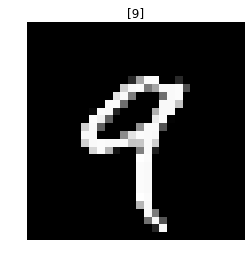

In [49]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy())

In [50]:
# see if train_loader is giving only nines
print(type(train_loader))

count = 0

for x_, y in train_loader:
    count+= 1
    # print(x_)
    print(y)
    if count == 5:
        break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([9])
tensor([9])
tensor([9])
tensor([9])
tensor([9])


In [60]:
# create data to be trained upon: around 200 images

train_custom_data = []

for i in range(1, 10):
    count = 0
    for item in train_loader:
        train_custom_data.append(item)
        count += 1
        if count == 4:
            break

In [61]:
print(len(train_custom_data))

36


In [62]:
input = torch.FloatTensor(batch_size, INPUT_SIZE)
noise = torch.FloatTensor(batch_size, (nz))

fixed_noise = torch.FloatTensor(SAMPLE_SIZE, nz).normal_(0,1)
fixed_labels = torch.zeros(SAMPLE_SIZE, NUM_LABELS)

for i in range(NUM_LABELS):
    for j in range(SAMPLE_SIZE // NUM_LABELS):
        fixed_labels[i*(SAMPLE_SIZE // NUM_LABELS) + j, i] = 1.0

label = torch.FloatTensor(batch_size)
one_hot_labels = torch.FloatTensor(batch_size, 10)

if cuda:
    model_d.cuda()
    model_g.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    one_hot_labels = one_hot_labels.cuda()
    fixed_labels = fixed_labels.cuda()

optim_d = optim.SGD(model_d.parameters(), lr=lr)
optim_g = optim.SGD(model_g.parameters(), lr=lr)
fixed_noise = Variable(fixed_noise)
fixed_labels = Variable(fixed_labels)

real_label = 1
fake_label = 0

for epoch_idx in range(epochs):
    model_d.train()
    model_g.train()


    d_loss = 0.0
    g_loss = 0.0
    for batch_idx, (train_x, train_y) in enumerate(train_custom_data):
        batch_size = train_x.size(0)
        train_x = train_x.view(-1, INPUT_SIZE)
        if cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()

        input.resize_as_(train_x).copy_(train_x)
        label.resize_(batch_size).fill_(real_label)
        one_hot_labels.resize_(batch_size, NUM_LABELS).zero_()
        one_hot_labels.scatter_(1, train_y.view(batch_size,1), 1)
        inputv = Variable(input)
        labelv = Variable(label)

        output = model_d(inputv, Variable(one_hot_labels))
        optim_d.zero_grad()
        errD_real = criterion(output, labelv)
        errD_real.backward()
        realD_mean = output.data.cpu().mean()

        one_hot_labels.zero_()
        rand_y = torch.from_numpy(
            np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
        one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
        noise.resize_(batch_size, nz).normal_(0,1)
        label.resize_(batch_size).fill_(fake_label)
        noisev = Variable(noise)
        labelv = Variable(label)
        onehotv = Variable(one_hot_labels)
        g_out = model_g(noisev, onehotv)
        output = model_d(g_out, onehotv)
        errD_fake = criterion(output, labelv)
        fakeD_mean = output.data.cpu().mean()
        errD = errD_real + errD_fake
        errD_fake.backward()
        optim_d.step()

        # train the G
        noise.normal_(0,1)
        one_hot_labels.zero_()
        rand_y = torch.from_numpy(
            np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
        one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
        label.resize_(batch_size).fill_(real_label)
        onehotv = Variable(one_hot_labels)
        noisev = Variable(noise)
        labelv = Variable(label)
        g_out = model_g(noisev, onehotv)
        output = model_d(g_out, onehotv)
        errG = criterion(output, labelv)
        optim_g.zero_grad()
        errG.backward()
        optim_g.step()

        d_loss += errD.data
        g_loss += errG.data
        if batch_idx % print_every == 0:
            print(
            "\t{} ({} / {}) mean D(fake) = {:.4f}, mean D(real) = {:.4f}".
                format(epoch_idx, batch_idx, len(train_loader), fakeD_mean,
                    realD_mean))

            g_out = model_g(fixed_noise, fixed_labels).data.view(
                SAMPLE_SIZE, 1, 28,28).cpu()
            save_image(g_out,
                '{}/{}_{}+nine.png'.format(
                    samples_dir, epoch_idx, batch_idx))


    print('Epoch {} - D loss = {:.4f}, G loss = {:.4f}'.format(epoch_idx,
        d_loss, g_loss))
#     if epoch_idx % save_every == 0:
#         torch.save(model_d.state_dict(),
#                     '{}/model_d_epoch_{}.pkl'.format(
#                         save_dir, epoch_idx))
#         torch.save(model_g.state_dict(),
#                     '{}/model_g_epoch_{}.pkl'.format(
#                         save_dir, epoch_idx))

	0 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 0 - D loss = 0.0557, G loss = 381.1879
	1 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 1 - D loss = 0.0155, G loss = 373.5790
	2 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 2 - D loss = 0.0446, G loss = 371.0468
	3 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 3 - D loss = 0.1623, G loss = 356.7957
	4 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 4 - D loss = 0.1008, G loss = 370.4163
	5 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 5 - D loss = 0.0396, G loss = 373.4356
	6 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 6 - D loss = 0.4512, G loss = 373.2437
	7 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 7 - D loss = 4.2195, G loss = 287.3220
	8 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch 8 - D loss = 0.0325, G loss = 438.2352
	9 (0 / 5949) mean D(fake) = 0.0000, mean D(real) = 1.0000
Epoch

In [74]:
import imageio

images = []
for e in range(epochs-1):
    img_name = 'samples/' + str(e + 1) + '_0+nine.png' 
    images.append(imageio.imread(img_name))
imageio.mimsave('hahaha_generation_animation.gif', images, fps=1)